# scoring using Convolutional Neural Network (CNN)

## Import The Required Libraries

In [ ]:
# basics
import sys

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import cv2
import pickle 
from PIL import Image
import shutil
# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.keras.utils import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation

from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend
import os
import random
import time
import datetime
from tensorflow.python.framework import ops
import inspect
import gc

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## utility functions

In [ ]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today() 

In [ ]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    #print(list(cnn_model.history.keys()))
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[1]
    val_auc_name = list(cnn_model.history.keys())[3]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps = len(test_generator))
    print(Y_pred)
   
    #y_pred = (Y_pred > 0.5).T[0]
    y_pred = np.argmax(Y_pred, axis=1)
    print(y_pred)
    #y_pred = (Y_pred > 0.5).T[0]
    y_pred = np.argmax(Y_pred, axis=1)
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred,labels=[0,1,2,3])
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    #print(counts)
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [[f'{names[i]}\n{percentages[i]}' for i in range(len(names))] for j in range(len(cm))]
    #print(labels)
    #labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['socre0', 'socre1','socre2','socre3']
    #print(cm)
    #print(labels)
    # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=True, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True)
    
  
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout();
    
    ## Summary Statistics
    
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    precision = np.mean(precision)  
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    recall = np.mean(recall)
    f1 = 2 * (precision * recall) / (precision + recall)
    TN = np.sum(np.diag(cm)) - np.sum(cm)
    FP = np.sum(cm, axis=0) - np.diag(cm)
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    specificity = np.mean(specificity)
    
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

## code


In [ ]:
batch_size = 64
project_path = r"C:\Users\jihed\Desktop\mobility-trento\Medical Imaging Diagnostics\video scoring"
train_path = project_path + r"\frames_data\train"
test_path = project_path + r"\frames_data\test"






### preprosessing

In [ ]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value

random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
#tf.set_random_seed(seed_value)
tf.random.set_seed(seed_value)
# 5. For layers that introduce randomness like dropout, make sure to set seed values 
#model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
#hyper_mode = 'grayscale'
#imagesize=(688, 1760, 3)
#imagesize=(688, 880,6)

In [ ]:


datagen = ImageDataGenerator( rescale=1.0/255.0,
                                   shear_range = 0.02,
                                   zoom_range = 0.02, rotation_range=10,
                                  fill_mode='nearest',
                                  horizontal_flip=True,
                                  
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

    # Define the generator that will read images from the fold directory and their labels
train_generator = datagen.flow_from_directory(directory = train_path, 
                                                        color_mode="rgb",
                                                        target_size = (240, 240), # image height , image width
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        seed=42)
    
test_generator = datagen.flow_from_directory(directory = test_path, 
                                                    color_mode="rgb",
                                                        target_size = (240, 240), # image height , image width
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        seed=42)

test_generator.reset()


Found 39232 images belonging to 4 classes.
Found 8029 images belonging to 4 classes.


In [ ]:
x,y = next(train_generator)
x.shape

(64, 240, 240, 3)

## Model

In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.vgg16.VGG16(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(240,240,3),
                     
                    
                     )
 
base_model.trainable=False

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
 
cnn = tf.keras.Sequential([
        base_model 
         ])

cnn.add(tf.keras.layers.BatchNormalization(renorm=True)),
cnn.add(tf.keras.layers.GlobalAveragePooling2D()),
#cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(activation='relu', units=1024))
cnn.add(tf.keras.layers.Dense(activation='relu', units=512))
cnn.add(tf.keras.layers.Dropout(0.4, seed=seed_value))
#cnn.add(tf.keras.layers.Dense(activation='relu', units=64))
#cnn.add(tf.keras.layers.Dense(activation='relu', units=16))
cnn.add(tf.keras.layers.Dense(activation='softmax', units=4))







cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

early = tf.keras.callbacks.EarlyStopping( patience=1,
                                          min_delta=0.001,
                                          restore_best_weights=True)
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=r"C:\Users\jihed\Desktop\mobility-trento\Medical Imaging Diagnostics\video scoring\output\checkpoints\my_modelframe_vgg16_{epoch}.h5",
   save_best_only=True,
    verbose=1

)
reduce1=tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,  # reduce the learning rate by a factor of 0.1
    patience=1,  # after 10 epochs with no improvement
    verbose=1)
callbacks=[early,checkpoint,reduce1]

# early stopping call back

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        3584      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0

In [ ]:
#cnn = tf.keras.models.load_model(r'C:\Users\jihed\Desktop\mobility-trento\Medical Imaging Diagnostics\video scoring\output\checkpoints\my_modelframe_resnet50_2.h5')

In [ ]:

epochs=3

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

print("start Model Trainning", date_time(1))
# fit model
history = cnn.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=1
                    )


print("Completed Model Trainning", date_time(1))

#create_charts(cnn, history)

start Model Trainning Timestamp: 2023-02-03 16:50:15
Epoch 1/3
613/613 [==============================] - ETA: 0s - loss: 0.8327 - accuracy: 0.6707 
Epoch 1: val_loss improved from inf to 1.51069, saving model to C:\Users\jihed\Desktop\mobility-trento\Medical Imaging Diagnostics\video scoring\output\checkpoints\my_modelframe_vgg16_1.h5
613/613 [==============================] - 22046s 36s/step - loss: 0.8327 - accuracy: 0.6707 - val_loss: 1.5107 - val_accuracy: 0.4026 - lr: 1.0000e-04
Epoch 2/3
613/613 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.8899 
Epoch 2: val_loss did not improve from 1.51069

Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
613/613 [==============================] - 21542s 35s/step - loss: 0.3295 - accuracy: 0.8899 - val_loss: 1.8254 - val_accuracy: 0.3686 - lr: 1.0000e-04
Completed Model Trainning Timestamp: 2023-02-04 04:56:44


In [ ]:
cnn.save(r"C:\Users\jihed\Desktop\mobility-trento\Medical Imaging Diagnostics\video scoring\output\models\Model_frame_vgg16.h5")

## Visualization

In [ ]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    #print(list(cnn_model.history.keys()))
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[1]
    val_auc_name = list(cnn_model.history.keys())[3]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps = len(test_generator))
    print(Y_pred)
   
    #y_pred = (Y_pred > 0.5).T[0]
    y_pred = np.argmax(Y_pred, axis=1)
    print(y_pred)
    #y_pred = (Y_pred > 0.5).T[0]
    y_pred = np.argmax(Y_pred, axis=1)
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred,labels=[0,1,2,3])
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    #print(counts)
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [[f'{names[i]}\n{percentages[i]}' for i in range(len(names))] for j in range(len(cm))]
    #print(labels)
    #labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['socre0', 'socre1','socre2','socre3']
    #print(cm)
    #print(labels)
    # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=True, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True)
   


    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.title('ROC AUC Curve')
    plt.show()
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout();
    
    ## Summary Statistics
    
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    precision = np.mean(precision)  
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    recall = np.mean(recall)
    f1 = 2 * (precision * recall) / (precision + recall)
    TN = np.sum(np.diag(cm)) - np.sum(cm)
    FP = np.sum(cm, axis=0) - np.diag(cm)
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    specificity = np.mean(specificity)
    
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

126/126 [==============================] - 3735s 30s/step
[[0.41341114 0.16439722 0.28686857 0.13532309]
 [0.03178778 0.8477486  0.10230169 0.01816187]
 [0.11195446 0.29811823 0.3218213  0.26810604]
 ...
 [0.21372654 0.38797888 0.38683462 0.01145991]
 [0.14806172 0.41054016 0.28836682 0.1530313 ]
 [0.26257926 0.49370483 0.16287114 0.0808447 ]]
[0 1 2 ... 1 1 1]


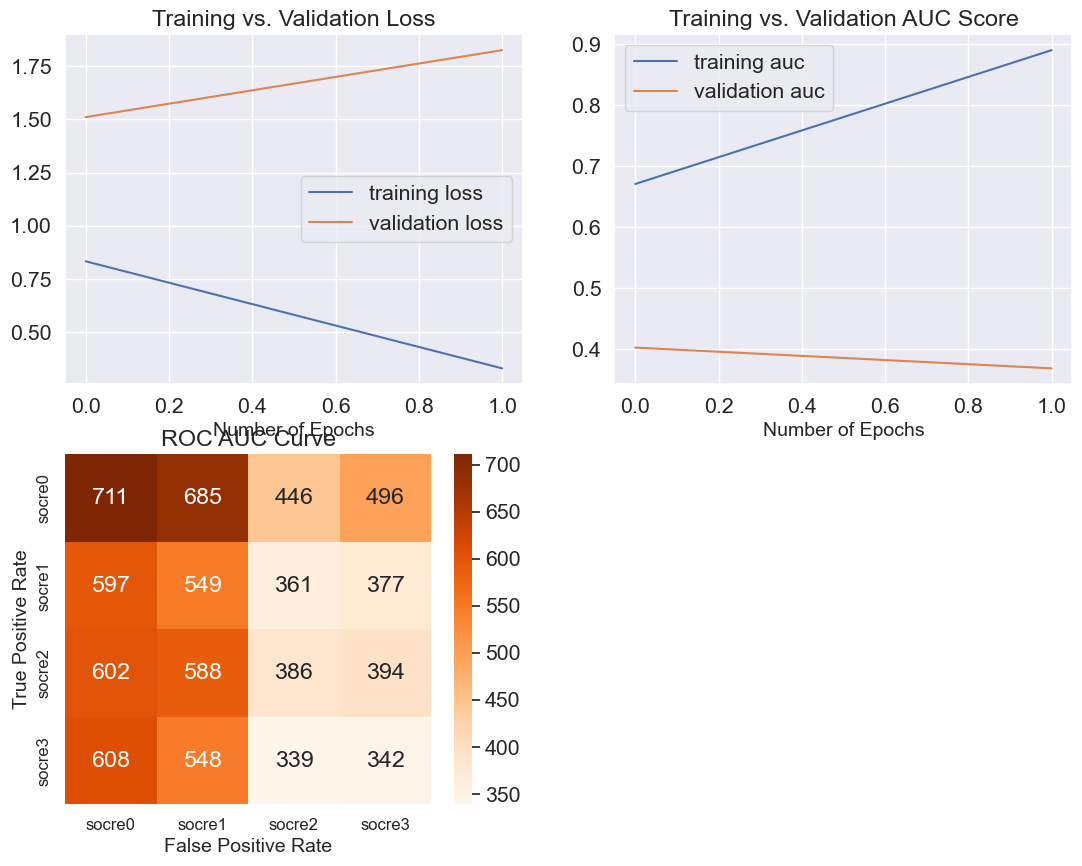

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Summary Statistics]
Accuracy = 24.76% | Precision = 24.46% | Recall = 24.44% | Specificity = 133.95% | F1 Score = 24.45%


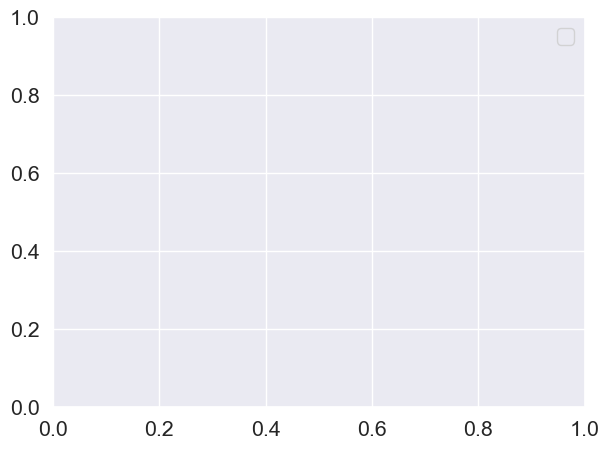

In [ ]:
create_charts(cnn,history)

In [ ]:
accuracy_score = cnn.evaluate(test_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

126/126 [==============================] - 3661s 29s/step - loss: 1.5006 - auc: 0.6666
[1.5005823373794556, 0.6665664315223694]
Accuracy: 66.6566%
Loss:  1.5005823373794556


In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(240,240,3),
                     
                    
                     )
 
base_model.trainable=False

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
 
cnn = tf.keras.Sequential([
        base_model 
         ])

cnn.add(tf.keras.layers.BatchNormalization(renorm=True)),
cnn.add(tf.keras.layers.GlobalAveragePooling2D()),
#cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(activation='relu', units=1024))
cnn.add(tf.keras.layers.Dense(activation='relu', units=512))
cnn.add(tf.keras.layers.Dropout(0.4, seed=seed_value))
#cnn.add(tf.keras.layers.Dense(activation='relu', units=64))
#cnn.add(tf.keras.layers.Dense(activation='relu', units=16))
cnn.add(tf.keras.layers.Dense(activation='softmax', units=4))







cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

early = tf.keras.callbacks.EarlyStopping( patience=1,
                                          min_delta=0.001,
                                          restore_best_weights=True)
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=r"C:\Users\jihed\Desktop\mobility-trento\Medical Imaging Diagnostics\video scoring\output\checkpoints\my_modelframe_resnet50_{epoch}.h5",
   save_best_only=True,
    verbose=1

)
reduce1=tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,  # reduce the learning rate by a factor of 0.1
    patience=1,  # after 10 epochs with no improvement
    verbose=1)
callbacks=[early,checkpoint,reduce1]


In [ ]:



STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

print("start Model Trainning", date_time(1))
# fit model
history = cnn.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=1
                    )


print("Completed Model Trainning", date_time(1))

#create_charts(cnn, history)

start Model Trainning Timestamp: 2023-02-04 09:05:25
Epoch 1/3
613/613 [==============================] - ETA: 0s - loss: 1.2529 - accuracy: 0.4287
Epoch 1: val_loss improved from inf to 1.47577, saving model to C:\Users\jihed\Desktop\mobility-trento\Medical Imaging Diagnostics\video scoring\output\checkpoints\my_modelframe_resnet50_1.h5
613/613 [==============================] - 7161s 12s/step - loss: 1.2529 - accuracy: 0.4287 - val_loss: 1.4758 - val_accuracy: 0.3092 - lr: 1.0000e-04
Epoch 2/3
613/613 [==============================] - ETA: 0s - loss: 0.9775 - accuracy: 0.5967 
Epoch 2: val_loss did not improve from 1.47577

Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
613/613 [==============================] - 7664s 13s/step - loss: 0.9775 - accuracy: 0.5967 - val_loss: 1.5506 - val_accuracy: 0.3455 - lr: 1.0000e-04
Completed Model Trainning Timestamp: 2023-02-04 13:12:31


In [ ]:
cnn.save(r"C:\Users\jihed\Desktop\mobility-trento\Medical Imaging Diagnostics\video scoring\output\models\Model_frame_resnet50.h5")

In [ ]:
accuracy_score = cnn.evaluate(test_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

126/126 [==============================] - 1235s 10s/step - loss: 1.4813 - accuracy: 0.3073
[1.4813481569290161, 0.3072611689567566]
Accuracy: 30.7261%
Loss:  1.4813481569290161


126/126 [==============================] - 1236s 10s/step
[[0.10740799 0.23081553 0.4446147  0.2171617 ]
 [0.19720641 0.20356575 0.13733561 0.46189225]
 [0.6684625  0.13985552 0.12254258 0.0691394 ]
 ...
 [0.04615834 0.17792296 0.39181888 0.38409978]
 [0.20862831 0.3340401  0.1782395  0.2790921 ]
 [0.08784962 0.16473399 0.19509907 0.55231726]]
[2 3 0 ... 2 1 3]


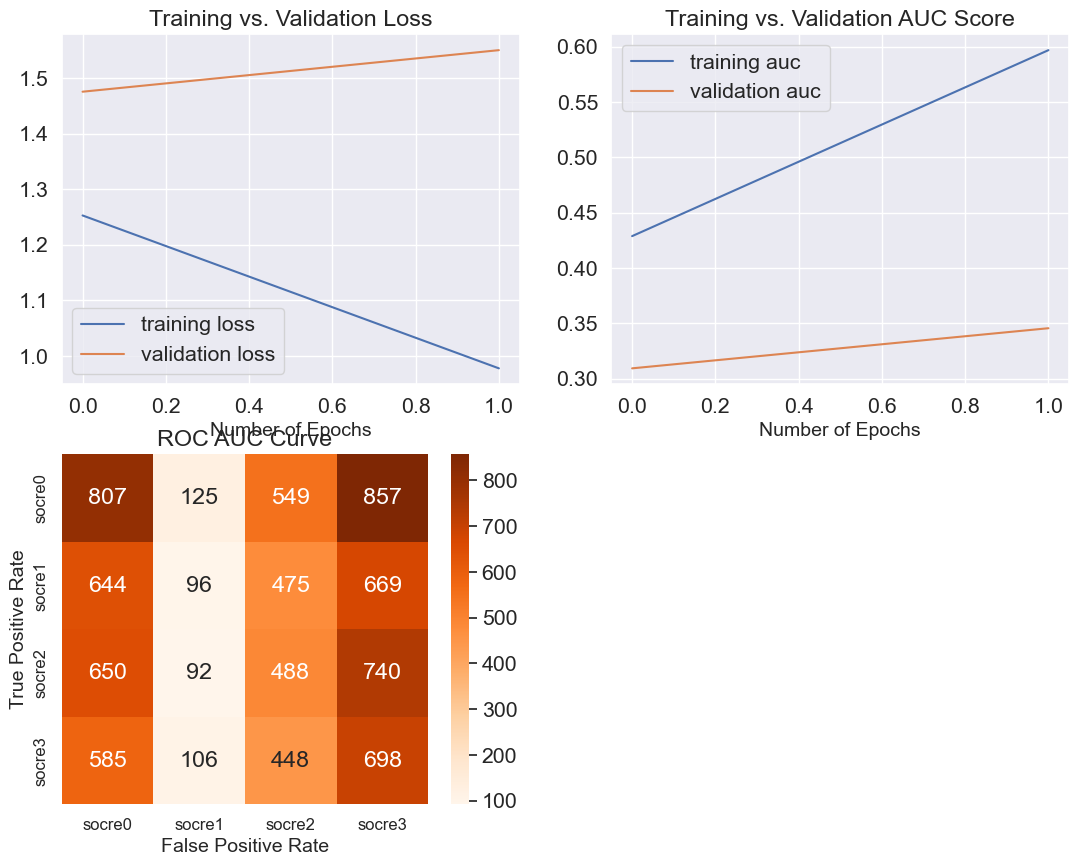

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Summary Statistics]
Accuracy = 26.02% | Precision = 25.35% | Recall = 25.60% | Specificity = 136.66% | F1 Score = 25.47%


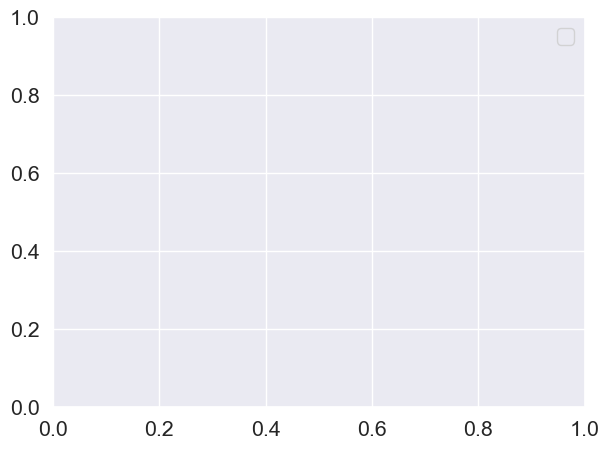

In [ ]:
create_charts(cnn,history)